<a href="https://colab.research.google.com/github/AnastasiaSperanskaya/MachineLearningITMO/blob/main/lab4/testDTLab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Деревья решений

## Определение дерева решений

* Это бинарное дерево.
* Каждой внутренней вершине приписана функция (предикат), которая возвращает TRUE или FALSE.
* Каждой листовой вершине приписан прогноз (например, в виде вероятности).

Могут быть многомерные признаки (линейные, метрические). Но с ними очень тяжело работать, на практике они редко применяются, поэтому мы будем использовать только одномерные предикаты:
$$ \beta_v (x;j,t)  = [x_j<t] $$
Здесь $v$ - это вершина, $x_j$ - значение $j$-го признака объекта $x$, $t$ - это порог 

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$.
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Находим наилучшее с точки зрения $Q$ разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Создадим вершину (для первого шага корневую), поместив в неё предикат $[x_j<t]$
5. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
6. Рекурсивно повторяем шаги 3-5 пока не выполнится критерий остановки.
7. Поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности). Для задачи регрессии - например, среднее значение целевой переменной по всем объектам в этом листе.  


При построении дерева, нужно понять, 1) какой признак $j$ выбрать на каждом шаге, 2) какой порог $t$ выбрать для создания предиката  $[x_j<t]$, 3) когда остановиться. 

Выбор признака и порога зависят от того, какой задан функционала качества $Q(X, j, t)$. Об этом в следующем разделе.

Критерии остановки:
* ограничение максимальной глубины дерева
* ограничение минимального числа объектов в листе
* ограничение максимального количества листьев в дереве
* purity (остановка, если все объекты в листе относятся к одному классу)




## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

Код для расчёта энтропии:

In [ ]:
def entropy(y):
    
    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

Здесь y - это массив значений целевой переменной

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
entropy(iris.target)

1.584962500721156

In [ ]:
entropy(iris.target[:100])

1.0

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

In [ ]:
entropy(y_test)

1.5775765559836064

In [ ]:
y_train.size

100

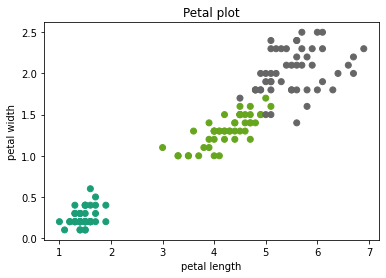

In [ ]:
plt.scatter(iris.data[:,2:3],iris.data[:,3:4],c=iris.target, cmap=plt.cm.Dark2)
plt.title('Petal plot')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.show()

Кажется, что если petal length меньше 2.5, то мы имеет разбиение, в котором одно поддерево будет содержать объекты только одного класса.

In [ ]:
df= pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                 columns= iris['feature_names'] + ['target'])

df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.drop(['target'], axis=1)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [ ]:
entropy(df['species'])

1.584962500721156

In [ ]:
sample1 = df[df['petal length (cm)']<2.5]

In [ ]:
entropy(sample1['species'])

0.0

In [ ]:
sample2 = df[df['petal length (cm)']>2.5]
entropy(sample2['species'])

1.0

Давайте попробуем другое разбиение.

In [ ]:
sample1 = df[df['petal length (cm)']<5]
sample2 = df[df['petal length (cm)']>=5]

In [ ]:
print(entropy(sample1['species']))
print(entropy(sample2['species']))

1.2602398669134125
0.2580186686648155


Как мы говорили ранее  энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

В нашем случае, в исходных данных энтропия была равна примерно 1.58. В первом разбиении 1.0, а во втором примерно 1.52. Оба разбиения уменьшили энтропию. Но первое разбиение уменьшило её сильнее, значит второе разбиение хуже. 

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

In [ ]:
grid = np.linspace(df['petal length (cm)'].min(), df['petal length (cm)'].max(), 10)

best_t = grid[0]
best_IG = -1
for t in grid:
  sample1 = df[df['petal length (cm)'] < t]
  sample2 = df[df['petal length (cm)'] >= t]
  IG = entropy (df['species']) - (entropy(sample1['species']) + entropy(sample2['species']))
  # print (IG)
  if IG > best_IG:
    best_t, best_IG  = t, IG

print (best_t) 

2.311111111111111


### Update

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 
Старая версия: $$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

Новая версия:
$$ Q = IG = H(R_v) - (\frac{|R_{v}|} {|R_{left}|} H(R_{left})+ \frac{|R_{v}|} {|R_{right}|} H(R_{right}))$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


## Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества, для выбора наилучшего разделения (с учетом признаком и порогов, для проверки критерия остановки.

Функционал качества $IG$.

Для набора данных iris реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию predict (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики точность (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [ ]:
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

df_train=pd.DataFrame(X_train)
df_train['y']=y_train

df_test=pd.DataFrame(X_test)
df_test['y']=np.nan

df_test_depth=pd.DataFrame(X_test)
df_test_depth['y']=np.nan

In [ ]:
class DecisionTree:
  def __init__(self):
    pass
  
  def fit(self, df):
    self.train = df
    self.result = pd.DataFrame([])

  def entropy(self,y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy

  def computeIG(self, df, left, right):
    if left.shape[0] == 0:
      return 0
    if right.shape[0] == 0:
      return 0
    return self.entropy(df['y']) - ((left.shape[0]/df.shape[0])*self.entropy(left['y']) + (right.shape[0]/df.shape[0])*self.entropy(right['y']))

  def find_best_split(self, df):
    grid = np.linspace(df[0].min(), df[0].max(), 10)
    best_t = grid[0]
    best_IG = -1
    for attr in range(df.shape[1]-1):
      grid = np.linspace(df[attr].min(), df[attr].max(), 10)
      for t in grid:
        left = df[df[attr] < t]
        right = df[df[attr] >= t]
        IG = self.computeIG(df, left, right)
        if IG > best_IG:
          best_t, best_IG  = t, IG
          best_attr = attr

    #print(best_t, best_attr, best_IG, ': best split')
    return best_t, best_attr   

  def build_tree(self, df_train, df_test, criterion, depth):
    if self.stop_criterion(criterion, df_train, depth)==1:
      #пометить все значения тестовой выборки как в тренировочной
      if df_test.shape[0] > 0:
        df_test['y'] = df_train['y'].value_counts().idxmax()
        #print(df_test)
        self.result = self.result.append(df_test)
    else:
      #вызвать рекурсивно правую и левую часть с depth+1
      t, attr = self.find_best_split(df_train)
      self.build_tree(df_train[df_train[attr] < t], df_test[df_test[attr] < t], criterion, depth+1)
      self.build_tree(df_train[df_train[attr] >= t], df_test[df_test[attr] >= t], criterion, depth+1)
    return

  def stop_criterion(self, criterion, df, depth):
    if criterion == 'max_depth':
      if depth == 5:
        return 1
    if criterion == 'max_obj_in_leave':
      if df.shape[0] <= 5:
        return 1
    if criterion == 'purity':
      df1 = df[df['y'] == 0]
      df2 = df[df['y'] == 1]
      df3 = df[df['y'] == 2]
      if df1.shape[0] == df.shape[0] or df2.shape[0] == df.shape[0] or df3.shape[0] == df.shape[0]:
        return 1
    return 0

  def predict(self, df_test, criterion):
    self.build_tree(self.train, df_test, criterion, 0)
    self.result.sort_index(inplace=True)
    return self.result
  

In [ ]:
from sklearn.metrics import accuracy_score
tree=DecisionTree()
tree.fit(df_train)
df_test = tree.predict(df_test, 'purity')
y_pred=df_test['y'].values
#print(y_pred)
#print(y_test)
accuracy_score(y_test, y_pred)

0.98

In [ ]:
from sklearn.metrics import accuracy_score
tree1=DecisionTree()
tree1.fit(df_train)
df_test_depth = tree1.predict(df_test_depth, 'max_depth')
y_pred_depth=df_test_depth['y'].values
accuracy_score(y_test, y_pred_depth)

0.98

# Пример из sklearn

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

In [ ]:
simple_tree = DecisionTreeClassifier()

Посмотрим на гиперпараметры алгоритмы. Кроме уже известных нам (выбор критерия, по кооторому счиатется функционал качества, критериев остановки), там есть ещё несколько любопытных настроек. В частности, можно ограничивать признаки, которые будут участвовать в предикатах. Зачем это может понадобиться?

In [ ]:
DecisionTreeClassifier?

In [ ]:
simple_tree.fit(X_train, y_train)
simple_tree.score(X_test, y_test)

0.98

In [ ]:
simple_tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
np.mean(cross_val_score(simple_tree, X_train, y_train, cv=5)) # будем использовать кросс-валидацию

0.9199999999999999

Попробуем улучшить этот результат, за счёт настройки гиперпараметров.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
tree_params = {'max_depth': np.arange(1, 11), 'min_samples_leaf':np.arange(1, 20)}

In [ ]:
tree_grid = GridSearchCV(simple_tree, tree_params)

In [ ]:
%time
tree_grid.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8

In [ ]:
tree_grid.score(X_test, y_test)

0.98

In [ ]:
tree_grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tree_grid.best_params_

{'max_depth': 6, 'min_samples_leaf': 1}

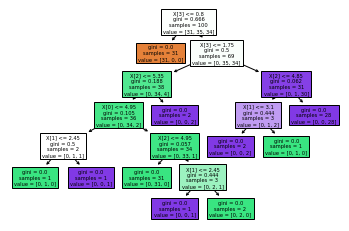

In [ ]:
from sklearn.tree import plot_tree

plt.figure()
clf = DecisionTreeClassifier().fit(iris.data, iris.target)
plot_tree(simple_tree, filled=True)
plt.show()

Визуализация дерева решений: https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py

# Композиция деревьев

Давайте сначала рассмотрим общую идею. Вы уже узнали разные семейства алгоритмов, подходящих для решения задачи классификации. Также вы научились выбирать наилучший алгоритм из заданного семейства и оценивать качество этих алгоритмов. Предположим, вы уже нашли самый лучший модель и повысить его качество больше не можете. В таком случае нужно применить техники объединения разных (более слабых) алгоритмов в один (более сильный). Эта техника назвается «ансамбли» или  «композиции». 

Ансамбль — это некая совокупность, части которой образуют единое целое. 

Несложно доказать, что, например, в задаче бинарной классификации, если предсказание каждого алгоритма не зависит от других алгоритмов, и если вероятность правильного ответа больше случайного угадывания (то есть в нащем примере больше 0.5), то тогда вероятность правильного ответа композации таких алгоритмов в целом возрастает с увеличением их количества и стремится к единице.



"Мудрость толпы". 

В 1906 году Фрэнсис Гальтон (это тот же, который придумал термин "регрессия") посещал выставку достижений животноводства. На выставке проводился конкурс, в рамках которого всем желающим предлагалось на глаз угадать точный вес быка. Около 800 человек пытались, но ни один  не угадал точный вес быка. Бык весил 1198 фунтов. Гальтон посчитал среднее значение по всем ответам, и получил 1197 фунтов.

На основе деревьев решений можно собрать более сильный классификатор: случайный лес (*random forest*) - один из самых распространённых ансамблей алгоритмов.

Опишем алгоритм и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf`. В задачах классификации строить каждое дерево до тех пор, пока в каждом листе не окажется по одному объекту. При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них.
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле.








## Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

In [ ]:
!pip install PyDrive
import pandas as pd
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"19z1VcT3sYf-jbv5Zv_KgJVqtci36hYJg"})
downloaded.GetContentFile('churn.csv')
churn = pd.read_csv('churn.csv')

In [ ]:
churn = churn.set_index('RowNumber')
churn

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
df = churn.loc[:, 'CreditScore':'Exited']
def label_encoder(data_: pd.DataFrame(), columns_name_: list):
    le = LabelEncoder()
    for i in columns_name_:
        le.fit(data_[i])
        data_[i] = le.transform(data_[i])
    return data_
df = label_encoder(df, ['Geography', 'Gender'])
train, test = train_test_split(df, test_size=0.33, random_state=42, stratify=df[['Exited']])
train.index = np.arange(len(train))
test.index = np.arange(len(test))
train
test

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,778,1,0,33,4,111063.73,2,1,0,83556.65,0
1,722,0,0,38,3,0.00,2,0,1,167984.72,0
2,549,0,0,25,5,0.00,2,0,0,190857.79,0
3,693,1,1,44,5,124601.58,2,1,1,46998.13,1
4,420,1,0,34,1,135549.90,1,0,0,149471.13,1
...,...,...,...,...,...,...,...,...,...,...,...
3295,646,0,1,24,8,0.00,2,0,0,92612.88,0
3296,701,0,1,43,2,0.00,2,1,1,165303.79,0
3297,622,1,0,34,7,98675.74,1,1,0,138906.85,1
3298,572,1,0,19,1,138657.08,1,1,1,16161.82,0


Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес". 

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from random import randrange

def subsample(dataset, ratio):
  sample = pd.DataFrame([])
  while len(sample) < ratio:
    index = randrange(len(dataset))
    df_tmp = pd.DataFrame([])
    df_tmp = df_tmp.append(dataset.iloc[index])
    cols = dataset.columns.tolist()
    df_tmp = df_tmp[cols]
    sample = sample.append(df_tmp)
  return sample

def bagging_predict(trees, row):
  predictions = np.array([])
  row_test_X = row.loc[:, 'CreditScore' : 'EstimatedSalary']
  for tree in trees:
    tree.predict(row_test_X)
    predictions = np.append(predictions, tree.predict(row_test_X))
  u, indices = np.unique(predictions, return_inverse=True)
  u[np.argmax(np.bincount(indices))]
  return u[np.argmax(np.bincount(indices))]

def random_forest(train, test, max_depth, sample_size, n_trees):
  trees = list()
  for i in range(n_trees):
    sample = subsample(train, sample_size)
    tree = DecisionTreeClassifier(max_depth=max_depth)
    sample_train_X = sample.loc[:, 'CreditScore' : 'EstimatedSalary']
    sample_train_y = sample['Exited']
    tree.fit(sample_train_X, sample_train_y)
    trees.append(tree)

  predictions = np.array([])
  for i in range(test.shape[0]-1):
    row = pd.DataFrame([])
    row = row.append(test.iloc[i])
    cols = test.columns.tolist()
    row = row[cols]
    predictions = np.append(predictions, bagging_predict(trees, row))
  return predictions

In [ ]:
random_forest(train, test, None, 6100, 1)

array([0., 0., 0., ..., 0., 1., 1.])